Elasticity solution for wedge-shaped problems
======================================

In this notebook an analytic solution for a wedge is constructed. Later on, we couple two wedge solutions to compute the displacement for a dipping fault with free surface.

Wedge solution
----------------------

Polar coordinates are given by
\begin{align}
    x &= r\cos(\theta) \\
    y &= r\sin(\theta) \\
    r &= \sqrt{x^2+y^2} \\
    \theta &= \arctan(y/x) \\
\end{align}

For a plane-strain problem, we assume there exists a biharmonic function $\phi$ such that [1]

\begin{align}
    2\mu u_r &= -\frac{\partial \phi}{\partial r} + (1-\nu)r\frac{\partial\psi}{\partial \theta} \\
    2\mu u_\theta &= -\frac{1}{r}\frac{\partial \phi}{\partial \theta} + (1-\nu)r^2\frac{\partial\psi}{\partial r} \\
    \sigma_{rr} &= \frac{1}{r}\frac{\partial \phi}{\partial r} +
    \frac{1}{r^2}\frac{\partial^2 \phi}{\partial \theta^2} \\
    \sigma_{\theta\theta} &= \frac{\partial^2 \phi}{\partial r^2} \\
    \sigma_{r\theta} &= -\frac{\partial }{\partial r} \left(
      \frac{1}{r}\frac{\partial \phi}{\partial\theta}
    \right) \\
\end{align}
where $\mu$ is the shear modulus, $\nu$ is Poisson's ratio, and $\phi$ and $\psi$ are related by
$$
\nabla^2\phi = \frac{\partial}{\partial r}\left(r\frac{\partial\psi}{\partial\theta}\right)
$$

Remark: Plane-stress is modelled in [1], therefore the formula are adjusted here for plane-strain.

[1] "Stress Singularites Resulting From Various Boundary Conditions in Angular Corners of Plates in Extension", M. L. Williams, Journal of Applied Mechanics, 19 (4), pp. 526-528.

In [1]:
from sympy import *
init_printing()

Assume

$$
\phi = r^{\lambda+1} \left(A_1\sin((\lambda+1)\theta) + A_2\cos((\lambda+1)\theta) + A_3\sin((\lambda-1)\theta) + A_4\sin((\lambda-1)\theta)\right)
$$
and
$$
\psi = r^{\lambda-1}\left(-\frac{4A_3}{\lambda-1}\cos((\lambda-1)t) + \frac{4A_4}{\lambda-1}\sin((\lambda-1)t)\right)
$$

In [2]:
r, t, x, y, lam = symbols('r theta x y lamda')
mu, nu, m, A0, A1, A2, A3, A4, S = symbols('mu nu m A_0 A_1 A_2 A_3 A_4 S')

phi = r**(lam+1) * (A1 * sin((lam+1)*t) + A2*cos((lam+1)*t) + A3*sin((lam-1)*t) + A4*cos((lam-1)*t))
psi = r**(lam-1) * (-4*A3/(lam-1)*cos((lam-1)*t) + 4*A4/(lam-1)*sin((lam-1)*t))

phi2 = phi.subs(lam, 2)
psi2 = psi.subs(lam, 2)
(phi2, psi2)

$\psi$ must be harmonic, i.e. $\nabla^2\psi=0$, and $\phi$ must be biharmonic, i.e. $\nabla^2(\nabla^2\phi=0)$:

In [3]:
def laplace(f):
    return f.diff(r, 2) + f.diff(r)/r + f.diff(t, 2)/r**2
(laplace(psi).simplify(), laplace(laplace(phi)).simplify())

The relation of $\phi$ and $\psi$ must be satisfied:

In [4]:
((r*psi.diff(t)).diff(r) - laplace(phi)).simplify()

Define displacement and stress:

In [5]:
def quants(phi, psi):
    ur = (-phi.diff(r) + (1-nu)*r*psi.diff(t)) / (2 * mu)
    ut = (-phi.diff(t)/r + (1-nu)*r**2*psi.diff(r)) / (2 * mu)
    srr = (phi.diff(r) / r + phi.diff(t, 2) / r**2)
    stt = phi.diff(r, 2)
    srt = -(phi.diff(t)/r).diff(r)
    return (ur.simplify(), ut.simplify(), srr.simplify(), stt.simplify(), srt.simplify())
ur, ut, srr, stt, srt = quants(phi, psi)

Check that stress-displacement relation is satisfied:

In [6]:
err = ur.diff(r)
ett = ut.diff(t)/r + ur/r
ert = (ur.diff(t)/r + ut.diff(r) - ut/r) / 2
((err - ((1-nu)*srr - nu*stt)/(2*mu)).simplify(),
 (ett - ((1-nu)*stt - nu*srr)/(2*mu)).simplify(),
 (ert - srt/(2*mu)).simplify())

The planes $\theta=0$ and $\theta=-\pi/3$ form an infinite wedge.
We set $\lambda=2$ and recover the coefficients $A_1,A_2,A_3,A_4$ which satisfy
\begin{align}
    u_\theta(r,-\pi/3) &= 0 \\
    u_r(r,-\pi/3) &= Sr^2 \\
    \sigma_{r\theta}(r,0) &= 0 \\
    \sigma_{\theta\theta}(r,0) &= 0
\end{align}

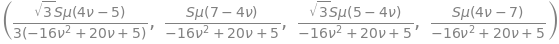

In [7]:
w1 = 0
w2 = -pi/3
mylam = 2
solution = linsolve([ut.subs(lam, mylam).subs(t, w2)/r**2,
                     ur.subs(lam, mylam).subs(t, w2)/r**2 - S,
                     srt.subs(lam, mylam).subs(t, w1)/r,
                     stt.subs(lam, mylam).subs(t, w1)/r],
         A1, A2, A3, A4)
a1, a2, a3, a4 = solution.args[0]
a1, a2, a3, a4 = a1.simplify(), a2.simplify(), a3.simplify(), a4.simplify()
(a1, a2, a3, a4)

We check that the boundary conditions are satisfied:

In [8]:
srr_s = srr.subs(lam, mylam).subs(A1, a1).subs(A2, a2).subs(A3, a3).subs(A4, a4).simplify()
stt_s = stt.subs(lam, mylam).subs(A1, a1).subs(A2, a2).subs(A3, a3).subs(A4, a4).simplify()
srt_s = srt.subs(lam, mylam).subs(A1, a1).subs(A2, a2).subs(A3, a3).subs(A4, a4).simplify()
(stt_s.subs(t, w1), srt_s.subs(t, w1))

In [9]:
ur_s = ur.subs(lam, mylam).subs(A1, a1).subs(A2, a2).subs(A3, a3).subs(A4, a4).simplify()
ut_s = ut.subs(lam, mylam).subs(A1, a1).subs(A2, a2).subs(A3, a3).subs(A4, a4).simplify()
(ur_s.subs(t, w2).simplify(), ut_s.subs(t, w2).simplify())

We convert the solution into Lua code:

In [10]:
def lua_code(expr):
    return rcode(expr).replace('cos', 'math.cos').replace('sin', 'math.sin').replace('sqrt', 'math.sqrt').replace('pi', 'math.pi')
print("local A_1 =", lua_code(a1))
print("local A_2 =", lua_code(a2))
print("local A_3 =", lua_code(a3))
print("local A_4 =", lua_code(a4))
print("local ur =", lua_code(ur.subs(lam, mylam).simplify()))
print("local ut =", lua_code(ut.subs(lam, mylam).simplify()))

local A_1 = (1.0/3.0)*math.sqrt(3)*S*mu*(4*nu - 5)/(-16*nu^2 + 20*nu + 5)
local A_2 = S*mu*(7 - 4*nu)/(-16*nu^2 + 20*nu + 5)
local A_3 = math.sqrt(3)*S*mu*(5 - 4*nu)/(-16*nu^2 + 20*nu + 5)
local A_4 = S*mu*(4*nu - 7)/(-16*nu^2 + 20*nu + 5)
local ur = (1.0/2.0)*r^2*(-3*A_1*math.sin(3*theta) - 3*A_2*math.cos(3*theta) - 4*A_3*nu*math.sin(theta) + A_3*math.sin(theta) - 4*A_4*nu*math.cos(theta) + A_4*math.cos(theta))/mu
local ut = (1.0/2.0)*r^2*(-3*A_1*math.cos(3*theta) + 3*A_2*math.sin(3*theta) - A_3*math.cos(theta) + A_4*math.sin(theta) + (4*nu - 4)*(A_3*math.cos(theta) - A_4*math.sin(theta)))/mu


Dipping fault
------------------

We now couple two wedge solutions to impose a displacement in a dipping fault with a free-surface condition, as illustrated in the following figure:

![fault](wedge.svg)

where $[\![ u ]\!] = u_A - u_B$. The A-side and B-side of the fault are separated by the fault plane $\theta=\omega$. Also note that the origin, marked with a circle, is at the intesection of the fault and the free surface.

We introduce potentials for the A-side and the B-side of the fault:

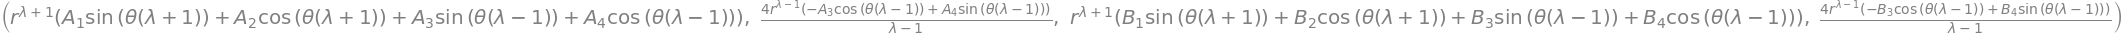

In [11]:
B1, B2, B3, B4 = symbols('B_1 B_2 B_3 B_4')

phiA = phi.simplify()
psiA = psi.simplify()
phiB = phiA.subs(A1, B1).subs(A2, B2).subs(A3, B3).subs(A4, B4).simplify()
psiB = psiA.subs(A1, B1).subs(A2, B2).subs(A3, B3).subs(A4, B4).simplify()
(phiA, psiA, phiB, psiB)

In [12]:
urA, utA, srrA, sttA, srtA = quants(phiA, psiA)
urB, utB, srrB, sttB, srtB = quants(phiB, psiB)

We remove the dependency on $r$ here to solve for the A and B coefficients:

In [13]:
sttA_e = (sttA*r**(1-lam)/lam).simplify()
srtA_e = (srtA*r**(1-lam)/lam).simplify()
sttB_e = (sttB*r**(1-lam)/lam).simplify()
srtB_e = (srtB*r**(1-lam)/lam).simplify()
(sttA_e, srtA_e, sttB_e, srtB_e)

In [14]:
def simp_A(expr):
    return factor(expr, *parsA).simplify()
def simp_B(expr):
    return factor(expr, *parsB).simplify()

parsA = (A1, A2, A3, A4)
urA_e = simp_A(urA*r**(-lam)*2*mu)
utA_e = simp_A(utA*r**(-lam)*2*mu)
parsB = (B1, B2, B3, B4)
urB_e = simp_B(urB*r**(-lam)*2*mu)
utB_e = simp_B(utB*r**(-lam)*2*mu)
(urA_e, utA_e, urB_e, utB_e)

We first compute coefficients which ensure the free-surface boundary condition. These calculations are independent for the A-side and B-side. Note that the A-wedge is given by planes $\theta=\pi$ and $\theta=\omega$, and the B-wedge is given by planes $\theta=0$ and $\theta=\omega$.

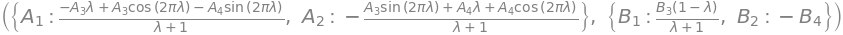

In [15]:
part_solution_A = solve([sttA_e.subs(t, pi),
                         srtA_e.subs(t, pi)],
                         *parsA)
part_solution_A = {k: v.simplify() for k, v in part_solution_A.items()}
part_solution_B = solve([sttB_e.subs(t, 0),
                         srtB_e.subs(t, 0)],
                         *parsB)
part_solution_B = {k: v.simplify() for k, v in part_solution_B.items()}
(part_solution_A, part_solution_B)

We can now express $A_1,A_2,B_1,B_2$ in terms of $A_3,A_4,B_3,B_3$, which we substitute in the following:

In [16]:
sttA_e2 = simp_A(sttA_e.subs(part_solution_A.items()))
srtA_e2 = simp_A(srtA_e.subs(part_solution_A.items()))
sttB_e2 = simp_B(sttB_e.subs(part_solution_B.items()))
srtB_e2 = simp_B(srtB_e.subs(part_solution_B.items()))
(sttA_e2, srtA_e2, sttB_e2, srtB_e2)

In [17]:
utA_e2 = simp_A(utA_e.subs(part_solution_A.items()))
urA_e2 = simp_A(urA_e.subs(part_solution_A.items()))
urB_e2 = simp_B(urB_e.subs(part_solution_B.items()))
utB_e2 = simp_B(utB_e.subs(part_solution_B.items()))
(urA_e2, utA_e2, urB_e2, utB_e2)

We now find the remaining coefficients for the imposed displacement on the fault plane $\omega = -\pi/3$. Note that we require the stress tensor to be continuous.

In [18]:
w = -pi/3
equations = [(sttA_e2 - sttB_e2).subs(t, w).simplify(),
             (srtA_e2 - srtB_e2).subs(t, w).simplify(),
             (utA_e2 - utB_e2).subs(t, w).simplify(),
             (urA_e2 - urB_e2 - S).subs(t, w).simplify()]
equations

In [19]:
part_equations_0 = [factor(equations[0] + equations[3], *parsA, *parsB).simplify(),
                    factor(equations[1] - equations[2], *parsA, *parsB).simplify()]
part_equations_0

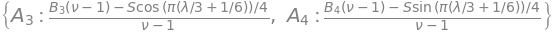

In [20]:
part_solution_0 = solve(part_equations_0, A3, A4, B3, B4)
part_solution_0 = {k: v.simplify() for k, v in part_solution_0.items()}
part_solution_0

In [21]:
part_equations_1 = [factor(equations[0].subs(part_solution_0.items()).simplify(), *parsB).simplify(),
                    factor(equations[1].subs(part_solution_0.items()).simplify(), *parsB).simplify()]

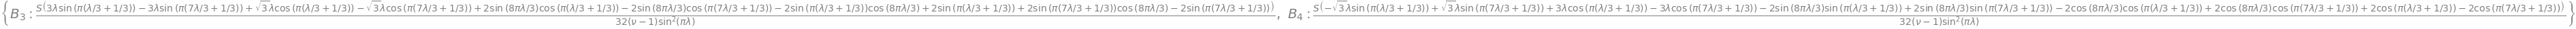

In [22]:
solution = solve(part_equations_1, B3, B4)
solution = {k: v.simplify() for k, v in solution.items()}
solution

Note that $\sin(\pi\lambda)$ appears in the denominator above.
Thus, $\lambda$ must not be an integer.

We substitute the parameters into the quantities for $\lambda = 0.5$:

In [23]:
mylam = 0.5
def subs_solution_A(expr):
    return expr.subs(part_solution_A.items()).subs(part_solution_0.items()).subs(solution.items()).subs(lam, mylam)
def subs_solution_B(expr):
    return expr.subs(part_solution_B.items()).subs(part_solution_0.items()).subs(solution.items()).subs(lam, mylam)

In [24]:
srrA_s = subs_solution_A(srrA).simplify()
sttA_s = subs_solution_A(sttA).simplify()
srtA_s = subs_solution_A(srtA).simplify()
urA_s = subs_solution_A(urA).simplify()
utA_s = subs_solution_A(utA).simplify()

srrB_s = subs_solution_B(srrB).simplify()
sttB_s = subs_solution_B(sttB).simplify()
srtB_s = subs_solution_B(srtB).simplify()
urB_s = subs_solution_B(urB).simplify()
utB_s = subs_solution_B(utB).simplify()

In the following we test whether the boundary conditions are satisifed.

In [25]:
(sttA_s.subs(t, pi).simplify(),
 srtA_s.subs(t, pi).simplify(),
 sttB_s.subs(t, 0).simplify(),
 srtB_s.subs(t, 0).simplify())

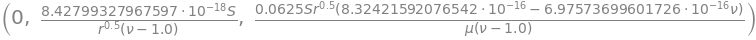

In [26]:
((sttA_s.subs(t, w)-sttB_s.subs(t, w)).simplify().evalf(),
 (srtA_s.subs(t, w)-srtB_s.subs(t, w)).simplify().evalf(),
 (utA_s.subs(t, w)-utB_s.subs(t, w)).simplify().evalf())

In [27]:
((urA_s.subs(t, w) - urB_s.subs(t, w) - S).simplify() + S).evalf().simplify()

Lastly, we generate Lua code for the A-side and the B-side:

In [28]:
def lua_code_cse(var_expr_pairs):
    vs, es = zip(*var_expr_pairs)
    e_cse = cse(es)
    for k, v in e_cse[0]:
        print("local {} = {}".format(k, lua_code(v)))
    for k, v in zip(vs, e_cse[1]):
        print("local {} = {}".format(k, lua_code(v)))

$B_3$ and $B_4$

In [29]:
lua_code_cse(solution.items())

local x0 = math.pi*((1.0/3.0)*lamda + 1.0/3.0)
local x1 = math.sin(x0)
local x2 = 2*x1
local x3 = math.pi*((7.0/3.0)*lamda + 1.0/3.0)
local x4 = math.sin(x3)
local x5 = 2*x4
local x6 = 3*lamda
local x7 = math.cos(x0)
local x8 = math.sqrt(3)*lamda
local x9 = math.cos(x3)
local x10 = math.pi*lamda
local x11 = (8.0/3.0)*x10
local x12 = math.sin(x11)
local x13 = 2*x7
local x14 = 2*x9
local x15 = math.cos(x11)
local x16 = (1.0/32.0)*S/((nu - 1)*math.sin(x10)^2)
local B_3 = x16*(x1*x6 + x12*x13 - x12*x14 - x15*x2 + x15*x5 + x2 - x4*x6 - x5 + x7*x8 - x8*x9)
local B_4 = x16*(-x1*x8 - x12*x2 + x12*x5 - x13*x15 + x13 + x14*x15 - x14 + x4*x8 + x6*x7 - x6*x9)


$A_3$ and $A_4$

In [30]:
lua_code_cse(part_solution_0.items())

local x0 = nu - 1
local x1 = 1.0/x0
local x2 = math.pi*((1.0/3.0)*lamda + 1.0/6.0)
local x3 = (1.0/4.0)*S
local A_3 = x1*(B_3*x0 - x3*math.cos(x2))
local A_4 = x1*(B_4*x0 - x3*math.sin(x2))


$A_1$ and $A_2$

In [31]:
lua_code_cse(part_solution_A.items())

local x0 = 1.0/(lamda + 1)
local x1 = 2*math.pi*lamda
local x2 = math.cos(x1)
local x3 = math.sin(x1)
local A_1 = x0*(-A_3*lamda + A_3*x2 - A_4*x3)
local A_2 = -x0*(A_3*x3 + A_4*lamda + A_4*x2)


$B_1$ and $B_2$

In [32]:
lua_code_cse(part_solution_B.items())

local B_2 = -B_4
local B_1 = B_3*(1 - lamda)/(lamda + 1)


In [33]:
urA

A-side: $u_r$ and $u_\theta$

In [34]:
lua_code_cse([('urA', urA), ('utA', utA)])

local x0 = lamda - 1
local x1 = theta*x0
local x2 = math.sin(x1)
local x3 = math.cos(x1)
local x4 = A_3*x2 + A_4*x3
local x5 = lamda + 1
local x6 = theta*x5
local x7 = math.sin(x6)
local x8 = math.cos(x6)
local x9 = (1.0/2.0)*r^lamda/mu
local x10 = A_4*x2
local x11 = A_3*x3
local urA = x9*(4*x4*(1 - nu) - x5*(A_1*x7 + A_2*x8 + x4))
local utA = x9*(-A_1*x5*x8 + A_2*x5*x7 + x0*x10 - x0*x11 + (4*nu - 4)*(-x10 + x11))


B-side: $u_r$ and $u_\theta$

In [35]:
lua_code_cse([('urB', urB), ('utB', utB)])

local x0 = lamda - 1
local x1 = theta*x0
local x2 = math.sin(x1)
local x3 = math.cos(x1)
local x4 = B_3*x2 + B_4*x3
local x5 = lamda + 1
local x6 = theta*x5
local x7 = math.sin(x6)
local x8 = math.cos(x6)
local x9 = (1.0/2.0)*r^lamda/mu
local x10 = B_4*x2
local x11 = B_3*x3
local urB = x9*(4*x4*(1 - nu) - x5*(B_1*x7 + B_2*x8 + x4))
local utB = x9*(-B_1*x5*x8 + B_2*x5*x7 + x0*x10 - x0*x11 + (4*nu - 4)*(-x10 + x11))


A-side: $u_{r,r}, u_{r,\theta}, u_{\theta,r}, u_{\theta,\theta}$

In [36]:
lua_code_cse([('urA_r', urA.diff(r)), ('urA_t', urA.diff(t)), ('utA_r', utA.diff(r)), ('utA_t', utA.diff(t))])

local x0 = lamda - 1
local x1 = theta*x0
local x2 = math.sin(x1)
local x3 = A_3*x2
local x4 = math.cos(x1)
local x5 = A_4*x4
local x6 = x3 + x5
local x7 = lamda + 1
local x8 = theta*x7
local x9 = math.sin(x8)
local x10 = A_1*x9
local x11 = math.cos(x8)
local x12 = A_2*x11
local x13 = (1.0/2.0)*r^lamda/mu
local x14 = lamda*x13/r
local x15 = 4*nu
local x16 = A_3*x4
local x17 = x0*x16
local x18 = A_4*x2
local x19 = x0*x18
local x20 = x17 - x19
local x21 = A_1*x11*x7
local x22 = A_2*x7*x9
local x23 = x15 - 4
local x24 = x7^2
local x25 = x0^2
local urA_r = x14*(4*x6*(1 - nu) - x7*(x10 + x12 + x6))
local urA_t = x13*(x20*(4 - x15) + (-lamda - 1)*(x20 + x21 - x22))
local utA_r = x14*(-x17 + x19 - x21 + x22 + x23*(x16 - x18))
local utA_t = x13*(x10*x24 + x12*x24 + x23*(-x0*x3 - x0*x5) + x25*x3 + x25*x5)


B-side: $u_{r,r}, u_{r,\theta}, u_{\theta,r}, u_{\theta,\theta}$

In [37]:
lua_code_cse([('urB_r', urB.diff(r)), ('urB_t', urB.diff(t)), ('utB_r', utB.diff(r)), ('utB_t', utB.diff(t))])

local x0 = lamda - 1
local x1 = theta*x0
local x2 = math.sin(x1)
local x3 = B_3*x2
local x4 = math.cos(x1)
local x5 = B_4*x4
local x6 = x3 + x5
local x7 = lamda + 1
local x8 = theta*x7
local x9 = math.sin(x8)
local x10 = B_1*x9
local x11 = math.cos(x8)
local x12 = B_2*x11
local x13 = (1.0/2.0)*r^lamda/mu
local x14 = lamda*x13/r
local x15 = 4*nu
local x16 = B_3*x4
local x17 = x0*x16
local x18 = B_4*x2
local x19 = x0*x18
local x20 = x17 - x19
local x21 = B_1*x11*x7
local x22 = B_2*x7*x9
local x23 = x15 - 4
local x24 = x7^2
local x25 = x0^2
local urB_r = x14*(4*x6*(1 - nu) - x7*(x10 + x12 + x6))
local urB_t = x13*(x20*(4 - x15) + (-lamda - 1)*(x20 + x21 - x22))
local utB_r = x14*(-x17 + x19 - x21 + x22 + x23*(x16 - x18))
local utB_t = x13*(x10*x24 + x12*x24 + x23*(-x0*x3 - x0*x5) + x25*x3 + x25*x5)
